In [2]:
import os
import cv2
import glob
import torch
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import random
import math
from collections import defaultdict
from matplotlib import pyplot as plt
import umap
from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist 

In [3]:
class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.masks = {}
        
        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)
        
        # Store tumor type in self.labels (0 = nonrecurrent, 1 = recurrent)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            mask_name = slide_num + tissue_num
            
            
            if mask_name not in self.masks:
                self.masks[mask_name] = np.zeros((224, 224), dtype=np.uint8)
            else:
                img_array = np.array(Image.open(img).convert("L"))
                both_zero_mask = (img_array == 0) & (self.masks[mask_name] == 0)
                self.masks[mask_name] = np.where(both_zero_mask, 0, 255).astype(np.uint8)
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
               
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        slide_num = self.image_files[idx].split("/")[-1].split("_")[0][:6]
        tissue_num = self.image_files[idx].split("/")[-1].split("_")[0][6:]
        channel = self.image_files[idx].split("/")[-1][9:-4]
        mask_name = slide_num + tissue_num
        image = Image.open(self.image_files[idx]).convert('L') 
        mask = Image.fromarray(self.masks[mask_name])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, label, mask, channel  # Return image, label, its underlying mask, and its channel (mz mob combination)

In [4]:
# define transformations (if needed)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# create dataset and dataloader
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_3snr_greyscale/'
dataset = SingleChannelDataset(folder_path, transform=None)
print(dataset[0][1])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

1


In [5]:
def plot_sampled_patches(image, coordinates, width, height, ax):
    """
    Plot the original image with bounding boxes indicating the sampled patches.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of sampled patches.
        width (int): width of the patch.
        height (int): height of the patch.
    """
    image_copy = image.copy()
    image_array = np.array(image_copy)
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    
    for (x_start, y_start) in coordinates:
        top_left = (y_start, x_start)
        bottom_right = (y_start + width, x_start + height)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)

    ax.imshow(image)
    ax.axis('off')  # Turn off axes
    return ax

In [6]:
import numpy as np
from PIL import Image

def construct_patches(img, width=32, height=32):  # Now takes a PIL Image object
    """
    Cuts a PIL Image object into patches and converts each patch to a NumPy array.

    Args:
        img: A PIL Image object.
        width: width of the patch (default: 32 for 224x224 image).
        height: height of the patch (default: 32 for 224x224 image).

    Returns:
        A list of NumPy arrays, where each array represents a patch.
        Returns None if there's an error processing the image.
    """
    img_array = np.array(img)  # Convert PIL Image to NumPy array
    patches = []
    for i in range(0, img_array.shape[0], width):  # Iterate over rows
        for j in range(0, img_array.shape[1], height):  # Iterate over columns
            patch = img_array[i:i + width, j:j + height,:]  # Extract patch
            patches.append(patch)

    return patches
    

In [7]:
def quilting_image(patches_a, patches_b, patch_size, percentage_a=0.5):
    """
    Reconstructs an image by randomly picking patches from two lists,
    with a specified percentage of patches coming from list A.

    Args:
        patches_a: A list of NumPy arrays (patches from image A).
        patches_b: A list of NumPy arrays (patches from image B).
        percentage_a: The percentage of patches to be selected from patches_a (default: 0.5).

    Returns:
        A PIL Image object representing the reconstructed image, or None if there's an error.
    """
    
    
    
    if len(patches_a) != len(patches_b):  # patch counts must match
        raise ValueError("Length of both lists must match!")
    
    num_rows = int(math.sqrt(len(patches_a)))  # number of patches per row is square root of length of patch list
    
    try:
        quilted_image = np.zeros((num_rows * patch_size, num_rows * patch_size), dtype=np.uint8)
        patch_index = 0
        for i in range(num_rows):
            for j in range(num_rows):
                # choose between A and B based on percentage_a
                if random.random() < percentage_a:  # random.random() returns a float between 0 and 1
                    chosen_patch = patches_a[patch_index]
                else:
                    chosen_patch = patches_b[patch_index]

                row_start = i * patch_size
                row_end = row_start + patch_size
                col_start = j * patch_size
                col_end = col_start + patch_size
                quilted_image[row_start:row_end, col_start:col_end] = chosen_patch
                patch_index += 1
        
        return Image.fromarray(quilted_image)

    except Exception as e:
        print(f"Error reconstructing image: {e}")
        return None

In [8]:
def create_patched_image(patches, patch_size):
    # Check if we have the right number of arrays
    patches_per_dimension = 224//patch_size
    if len(patches) != patches_per_dimension**2:
        raise ValueError(f"Number of patches  ({len(patches)})cannot be used to form a 224x224 image given patch size {patch_size}")
    
    # Determine if we're working with grayscale or color images
    if len(patches[0].shape) == 3:
        # Color images
        height, width, channels = patches[0].shape
        result = np.zeros((patches_per_dimension * height, patches_per_dimension * width, channels))
    else:
        # Grayscale images
        height, width = patches[0].shape
        result = np.zeros((patches_per_dimension * height, patches_per_dimension * width))
    
    # Place each array in the correct position
    for i in range(patches_per_dimension):
        for j in range(patches_per_dimension):
            index = i * patches_per_dimension + j
            row_start = i * height
            col_start = j * width
            result[row_start:row_start + height, col_start:col_start + width] = patches[index]
    
    return result

In [9]:
def sample_patches(img, max_patches, patch_size, min_distance):
    """
    Randomly sample n coordinates from white regions (value 255) in a binary image.
    
    Args:
        img: PIL Image or numpy array with binary values (0, 255)
        max_patches: maximum number of patches
        patch_size: the size of the patch
        overlap: acceptable overlap between patches
        
    Returns:
        numpy.ndarray: Array of shape (max_patches, 2) containing (x, y) coordinates
    """
    # convert PIL Image to numpy array if needed
    if isinstance(img, Image.Image):
        img_array = np.array(img)
    else:
        img_array = img
            
    # find coordinates of white pixels in the mask image (value 255)
    white_pixels = np.where(img_array == 255)
    all_coords = np.column_stack((white_pixels[0], white_pixels[1]))
    
    # create a set of tuples for faster membership testing
    # note that we use (y,x) format for coordinates since that's how NumPy indexes images
    coords_set = set(map(tuple, all_coords))
    
    # find valid candidate points that have the bottom right coordinate also in white region
    valid_candidates = []
    valid_indices = []
    

    for idx, (y, x) in enumerate(all_coords):
        factor = random.randint(1, 3)
        bottom_right_coord = (y + patch_size*factor, x + patch_size)  # Note: offset is (x,y) but coords are (y,x)
        if bottom_right_coord in coords_set:
            valid_candidates.append((y, x))
            valid_indices.append(idx)
    
    valid_candidates = np.array(valid_candidates)
    
    # check if we have enough white pixels
    if len(valid_candidates) < max_patches:
        raise ValueError(f"Not enough valid candidates ({len(valid_candidates)}) to sample {max_patches} coordinates")
    
    # create a mask that will be updated to 0 in regions where points are already placed
    # we'll start with all 1s where valid points exist
    point_mask = np.zeros_like(img_array, dtype=bool)
    for y, x in valid_candidates:
        point_mask[y, x] = True
        
    # array to store sampled coordinates
    sampled_coords = []
    
    for _ in range(max_patches):
        # if we've eliminated all possible points, break
        if not np.any(point_mask):
            break
            
        # get indices where mask is True (valid points remain)
        remaining_y, remaining_x = np.where(point_mask)
        remaining_indices = np.arange(len(remaining_y))
        
        # shuffle to randomly sample
        np.random.shuffle(remaining_indices)
        
        # try points in random order
        found_point = False
        for idx in remaining_indices:
            y, x = remaining_y[idx], remaining_x[idx]
            
            # if this point and its offset are both valid
            if (y, x) in coords_set and (y + patch_size, x + patch_size) in coords_set:
                sampled_coords.append((y, x))
                found_point = True
                
                # create a circular mask to remove points that are too close
                y_indices, x_indices = np.ogrid[-y:img_array.shape[0]-y, -x:img_array.shape[1]-x]
                dist_mask = y_indices*y_indices + x_indices*x_indices <= min_distance*min_distance
                point_mask[dist_mask] = False
                
                break
        # we couldn't find another valid point        
        if not found_point:
            break
    
    # check if we got enough samples
    if len(sampled_coords) < max_patches:
        print(f"Warning: Could only find {len(sampled_coords)} points with minimum distance {min_distance} between patches.")
    return sampled_coords

In [10]:
def sample_random_patches_in_mask(mask, n_patches, patch_size, min_distance=5, seed=None):
    """
    Randomly sample n patches within a binary mask with varying widths.
    Ensures minimum distance between patch top-left corners and that entire patches are within the mask.
    
    Parameters:
        mask (np.ndarray): Binary mask where 1/True indicates the object region
        n_patches (int): Number of patches to sample
        patch_size (int): base patch size
        min_distance (int): Minimum distance between top-left corners of patches
        seed (int, optional): Random seed for reproducibility
        
    Returns:
        List[Tuple[int, int, int]]: List of tuples (x_start, y_start, width_multiplier)
                                   where width_multiplier is 1, 2, or 3
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Find coordinates of pixels within the mask
    y_coords, x_coords = np.where(mask > 0)
    
    if len(y_coords) == 0:
        raise ValueError("Mask is empty, no object detected")
    
    # Create array of valid coordinates
    valid_coords = np.column_stack((x_coords, y_coords))
    
    patches = []
    selected_points = []
    mask_height, mask_width = mask.shape[:2]
    
    # Try to sample n patches
    attempts = 0
    max_attempts = n_patches * 50  # Limit attempts to avoid infinite loops
    
    while len(patches) < n_patches and attempts < max_attempts:
        attempts += 1
        
        # Randomly select a point within the mask
        idx = np.random.randint(0, len(valid_coords))
        x, y = valid_coords[idx]
        
        # Randomly select width multiplier (1, 2, or 3)
        width_multiplier = random.choice([1, 2, 3])
        current_width = patch_size * width_multiplier
        
        # Check if the entire patch (including bottom-right) stays within the image bounds
        if x + patch_size > mask_height or y + current_width > mask_width:
            continue
        
        # Check if the entire patch (including bottom-right) is within the mask
        patch_region = mask[x:x+patch_size, y:y+current_width]
        if not np.all(patch_region):
            continue
        
        # Check minimum distance constraint
        if selected_points:
            distances = cdist(np.array([(x, y)]), np.array(selected_points))
            if np.min(distances) < min_distance:
                continue
        
        # Add patch if it meets all criteria
        patches.append((x, y, width_multiplier))
        selected_points.append((x, y))
        
    return patches

def plot_sampled_patches(image, patches, patch_size, ax):
    """
    Plot the original image with bounding boxes indicating the sampled patches.
    
    Parameters:
        image (np.ndarray): The input image as a NumPy array
        patches (List[Tuple[int, int, int]]): List of (x_start, y_start, width_multiplier)
        base_width (int): Base width for patches
        height (int): Height for patches
        ax: Matplotlib axis to plot on
    """
    image_copy = image.copy()
    image_array = np.array(image_copy)
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
   
    for (x_start, y_start, width_multiplier) in patches:
        current_width = patch_size * width_multiplier
        top_left = (y_start, x_start)
        bottom_right = (y_start + current_width, x_start + patch_size)
        cv2.rectangle(image, top_left, bottom_right, color=(255, 0, 0), thickness=1)
    
    ax.imshow(image)
    ax.axis('off')  # Turn off axes
    return ax

In [24]:
import numpy as np
import cv2
import random
from typing import List, Tuple
from scipy import ndimage

def advanced_patch_sampling(
    mask,
    patch_size: int,
    num_patches: int,
    min_overlap_percent: float = 0.5,
    prefer_central: bool = True,
    min_distance_between_patches: int = 0
) -> List[Tuple[int, int]]:
    """
    Advanced sampling of square patches within a binary mask with minimum overlap.
    
    Args:
        mask: Binary mask (0 and 1/255 values)
        patch_size: Size of square patches (width/height in pixels)
        num_patches: Number of patches to sample
        min_overlap_percent: Minimum percentage of patch that must overlap with mask
        prefer_central: If True, prefer sampling from central regions of the mask
        min_distance_between_patches: Minimum pixel distance between patch centers
            
    Returns:
        List of (x, y) top-left coordinates for sampled patches
    """
    mask = np.array(mask)
    # Ensure mask is binary (0 or 1)
    binary_mask = (mask > 0).astype(np.uint8)
    height, width = binary_mask.shape[:2]
    
    # 1. Calculate distance transform - how far is each pixel from the mask edge
    # First get the inverse (outside is 1, inside is 0)
    inv_mask = 1 - binary_mask
    # Calculate distance from outside region to each inside pixel
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
    
    # Optional: Create a probability map that favors central regions
    if prefer_central:
        # Normalize the distance transform to [0, 1]
        if dist_transform.max() > 0:  # Avoid division by zero
            prob_map = dist_transform / dist_transform.max()
        else:
            prob_map = dist_transform
    else:
        # Uniform sampling for pixels inside the mask
        prob_map = binary_mask.astype(float)
    
    # 2. Pre-compute valid sampling regions
    # A pixel can be a top-left corner if enough of the patch overlaps with the mask
    valid_regions = np.zeros((height, width), dtype=np.float32)
    
    # For each potential top-left position, calculate expected overlap
    for y in range(height - patch_size + 1):
        for x in range(width - patch_size + 1):
            patch_mask = binary_mask[y:y+patch_size, x:x+patch_size]
            overlap = np.sum(patch_mask) / (patch_size * patch_size)
            if overlap >= min_overlap_percent:
                # Save probability based on mean of distance transform in the patch
                patch_prob = prob_map[y:y+patch_size, x:x+patch_size].mean()
                valid_regions[y, x] = patch_prob
    
    # If no valid regions found, return empty list
    if np.sum(valid_regions) == 0:
        print("No valid patch regions found.")
        return []
    
    # 3. Sample patches based on the probability map
    patch_locations = []
    max_attempts = num_patches * 200  # Avoid infinite loop
    attempts = 0
    
    # Create a mask to track sampled regions
    sampling_mask = np.zeros((height, width), dtype=np.uint8)
    
    while len(patch_locations) < num_patches and attempts < max_attempts:
        attempts += 1
        
        # Flatten valid_regions and create probability distribution
        flat_indices = np.where(valid_regions.ravel() > 0)[0]
        
        if len(flat_indices) == 0:
            print("No more valid sampling locations.")
            break
            
        # Create probability distribution from valid regions
        probs = valid_regions.ravel()[flat_indices]
        probs = probs / np.sum(probs)
        
        # Sample index based on probability
        idx = np.random.choice(flat_indices, p=probs)
        y, x = np.unravel_index(idx, valid_regions.shape)
        
        # Check if this patch overlaps with previously sampled patches
        if min_distance_between_patches > 0:
            # Calculate patch center
            center_x = x + patch_size // 2
            center_y = y + patch_size // 2
            
            # Check for proximity to existing patches
            too_close = False
            for prev_x, prev_y in patch_locations:
                prev_center_x = prev_x + patch_size // 2
                prev_center_y = prev_y + patch_size // 2
                distance = np.sqrt((center_x - prev_center_x)**2 + (center_y - prev_center_y)**2)
                if distance < min_distance_between_patches:
                    too_close = True
                    break
            
            if too_close:
                # Temporarily reduce probability at this location
                valid_regions[y, x] *= 0.1
                continue
        
        # Accept this patch
        patch_locations.append((x, y))
        
        # Update valid_regions to reduce probability nearby
        if min_distance_between_patches > 0:
            # Create a circular mask of reduced probability
            y_coords, x_coords = np.ogrid[:height, :width]
            mask_y, mask_x = y + patch_size // 2, x + patch_size // 2
            dist_from_center = np.sqrt((x_coords - mask_x)**2 + (y_coords - mask_y)**2)
            
            # Calculate falloff (1 at distance 0, decreasing outward)
            falloff = np.clip(1 - dist_from_center / (min_distance_between_patches * 1.5), 0, 1)
            
            # Apply the falloff to reduce probability
            valid_regions = valid_regions * (1 - falloff * 0.9)
    
    if len(patch_locations) < num_patches:
        print(f"Warning: Could only find {len(patch_locations)} valid patches after {attempts} attempts")
        
    return patch_locations


<Axes: >

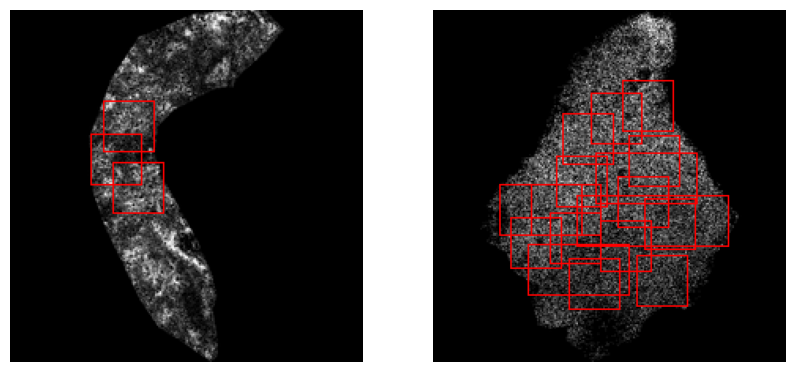

In [22]:

# Display some example images and their sampled coordinates
img1, label1, mask1, channel1 = dataset[1699] # example 1
img2, label2, mask2, channel2 = dataset[400] # example 2

coords1 = sample_random_patches_in_mask(np.array(mask1), 30, 32, 20, 42)
coords2 = sample_random_patches_in_mask(np.array(mask2), 30, 32, 20, 42)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plot_sampled_patches(img1, coords1, 32, ax=axes[0])
plot_sampled_patches(img2, coords2, 32, ax=axes[1])

In [16]:
def create_patch_collage(image, patches, patch_size, seed=None):
    """
    Create a square collage from random patches.
    
    Parameters:
        image (np.ndarray): The original image
        patches (List[Tuple[int, int, int]]): List of (x_start, y_start, width_multiplier)
        base_width (int): Base width for patches
        height (int): Height for patches
        seed (int, optional): Random seed for reproducibility
        
    Returns:
        np.ndarray: Collage image of size (7*height, 7*height, 3)
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Create empty collage (7×7 patch heights)
    collage_size = 7 * patch_size
    collage = np.zeros((collage_size, collage_size), dtype=np.uint8)

        # Convert image to grayscale if it's not already
    if len(image.shape) == 3:
        if image.shape[2] == 3:
            # Convert RGB to grayscale
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        elif image.shape[2] == 4:
            # Convert RGBA to grayscale
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
        else:
            raise ValueError(f"Unexpected number of channels: {image.shape[2]}")
    
    # Current position in the collage
    current_y = 0
    current_x = 0
    
    # Shuffle patches to use random ones
    available_patches = patches.copy()
    random.shuffle(available_patches)
    
    # Keep track of used patches
    used_patches = []
    
    # Fill the collage row by row
    while current_y < collage_size:
        # Reset x position for new row
        current_x = 0
        
        # Fill the current row
        while current_x < collage_size:
            # If we've used all patches, we can either stop or reuse patches
            if not available_patches:
                # Decide to reuse patches or leave the rest of the collage empty
                # Here we choose to reuse
                available_patches = used_patches.copy()
                random.shuffle(available_patches)
                used_patches = []
            
            # Get a patch
            x_start, y_start, width_multiplier = available_patches.pop(0)
            used_patches.append((x_start, y_start, width_multiplier))
            
            current_width = patch_size * width_multiplier
            
            # Extract the patch from the original image
            patch = image[x_start:x_start+patch_size, y_start:y_start+current_width].copy()
            
            # Calculate how much of the patch can fit in the remaining space of this row
            space_left = collage_size - current_x
            usable_width = min(current_width, space_left)
            
                        

            collage[current_y:current_y+patch_size, current_x:current_x+usable_width] = patch[:, :usable_width]
            
            # Update current x position
            current_x += usable_width
        
        # Move to the next row
        current_y += patch_size
    
    return collage


def display_collage(collage):
    """Display the collage image"""
    plt.figure(figsize=(5, 5))
    plt.imshow(collage, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

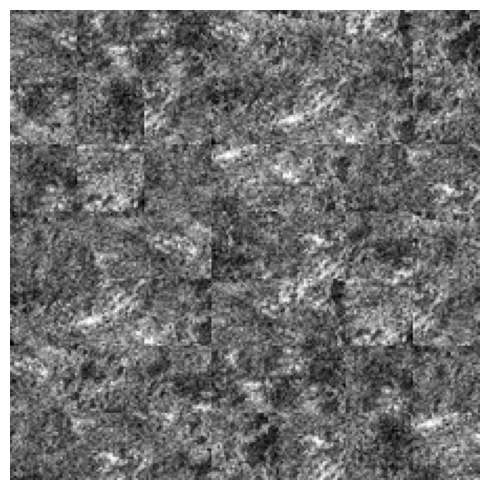

In [17]:
collage = create_patch_collage(np.array(img1), coords1, 32)

# Display the collage
display_collage(collage)

In [16]:
def extract_patches(image, coordinates, patch_size):
    """
    Extract patches from an image using the given coordinates.

    Parameters:
        image (np.ndarray): The input image as a NumPy array.
        coordinates (List[Tuple[int, int]]): List of top-left coordinates of patches.
        patch_size (int): Size of the square patch.

    Returns:
        List[np.ndarray]: A list of extracted patches as NumPy arrays.
    """
    patches = [
        image[x_start:x_start + patch_size, y_start:y_start + patch_size]
        for x_start, y_start in coordinates
    ]
    return patches

def create_patches_by_channel(dataset, max_patches=50, patch_size=16, overlap=0.5):
    """
    Construct a quited image dataset synthesized existing Dataset object

    Args:
        dataset: a Dataset object that contains the images
        max_patches: maximum number of patches that can be drawn on the image
        patch_size: the size of the patches
        overlap: how much two patches can overlap each other

    Returns:
        A directory containing generated quilted images
    """
    positive_patches_by_channel = defaultdict(list)
    negative_patches_by_channel = defaultdict(list)
    for img, label, mask, channel in dataset:
        coords = sample_coordinates_from_roi(mask, max_patches, patch_size, overlap) # sample maximum 32 patches of size 8x8
        patches = extract_patches(np.array(img), coords, patch_size)
        if label == 1:
            positive_patches_by_channel[channel].extend(patches)
        else:
            negative_patches_by_channel[channel].extend(patches)
    return positive_patches_by_channel, negative_patches_by_channel

positive_patches, negative_patches = create_patches_by_channel(dataset, 500, 16, 0.75)

In [28]:
patch_size = 16
num_patches = (224 // patch_size) ** 2
print("Number of patches per quilt:", num_patches)
positive_quilts_train = defaultdict(list)
positive_quilts_test = defaultdict(list)
negative_quilts_train = defaultdict(list)
negative_quilts_test = defaultdict(list)

all_channels = list(positive_patches.keys())
for channel in all_channels:
    # shuffle the patches up first
    positive_patches_train, positive_patches_test = train_test_split(positive_patches[channel], test_size= 0.3, random_state=42)
    negative_patches_train, negative_patches_test = train_test_split(negative_patches[channel], test_size= 0.3, random_state=42)

    # create numpy arrays of quilted images
    for i in range(0, len(positive_patches_train), num_patches):
        if i + num_patches <= len(positive_patches_train): # if the remaining number of patches are not enough to make a picture, ignore them
            quilted_np = create_patched_image(positive_patches_train[i:i + num_patches], patch_size)
            positive_quilts_train[channel].append(quilted_np)

    for i in range(0, len(positive_patches_test), num_patches):
        if i + num_patches <= len(positive_patches_test):
            quilted_np = create_patched_image(positive_patches_test[i:i + num_patches], patch_size)
            positive_quilts_test[channel].append(quilted_np)

    for i in range(0, len(negative_patches_train), num_patches):
        if i + num_patches <= len(negative_patches_train):
            quilted_np = create_patched_image(negative_patches_train[i:i + num_patches], patch_size)
            negative_quilts_train[channel].append(quilted_np)

    for i in range(0, len(negative_patches_test), num_patches):
        if i + num_patches <= len(negative_patches_test):
            quilted_np = create_patched_image(negative_patches_test[i:i + num_patches], patch_size)
            negative_quilts_test[channel].append(quilted_np)
    

Number of patches per quilt: 196


In [29]:
output_folder = "/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/"
positive_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/positive_train/"
positive_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/positive_test/"
negative_quilted_train = "/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/negative_train/"
negative_quilted_test = "/home/mass_spec_img/mass_spec_img/data/quilted_images_3snr/negative_test/"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(positive_quilted_train, exist_ok=True)
os.makedirs(positive_quilted_test, exist_ok=True)
os.makedirs(negative_quilted_train, exist_ok=True)
os.makedirs(negative_quilted_test, exist_ok=True)
# Save each array as a grayscale image
min_train_tissues = float('inf')
min_test_tissues = float('inf')
for channel in positive_quilts_train.keys():
    min_train_tissues = min(min_train_tissues, len(positive_quilts_train[channel]), len(negative_quilts_train[channel]))
    min_test_tissues = min(min_test_tissues, len(positive_quilts_test[channel]), len(negative_quilts_test[channel]))
print(min_train_tissues, min_test_tissues)
for channel in positive_quilts_train.keys():
    for i in range(min_train_tissues):
        img = Image.fromarray(positive_quilts_train[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(positive_quilted_train, f"Train_positive_{i}_{channel}.png"))

        img = Image.fromarray(negative_quilts_train[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(negative_quilted_train, f"Train_negative_{i}_{channel}.png"))
    for i in range(min_test_tissues):
        img = Image.fromarray(positive_quilts_test[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(positive_quilted_test, f"Test_positive_{i}_{channel}.png"))

        img = Image.fromarray(negative_quilts_test[channel][i].astype(np.uint8), mode='L')
        img.save(os.path.join(negative_quilted_test, f"Test_negative_{i}_{channel}.png"))


15 6


In [ ]:
output_folder = "grayscale_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Assuming you have a list of numpy arrays
numpy_arrays = [array1, array2, array3]  # Replace with your actual array list

# Save each array as a grayscale image
for i, array in enumerate(numpy_arrays):
    # Convert numpy array to PIL Image
    # Mode 'L' is for grayscale
    img = Image.fromarray(array.astype(np.uint8), mode='L')
    
    # Save the image with a sequential filename
    img.save(os.path.join(output_folder, f"image_{i}.png"))


In [108]:
class CustomQuiltedDataset(Dataset):
    def __init__(self, positive_quilts, negative_quilts, transform=None):
        self.images = []
        self.labels = []
        print(len(positive_quilts), len(negative_quilts))
        self.images.extend(positive_quilts)
        self.images.extend(negative_quilts)
        self.labels.extend([1] * len(positive_quilts))
        self.labels.extend([0] * len(negative_quilts))
        self.transform = transform
                
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [111]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

quilted_dataset = CustomQuiltedDataset(positive_quilts, negative_quilts, transform=transform)
quilted_dataloader = DataLoader(quilted_dataset, batch_size=32, shuffle=True)

5000 5000


In [112]:
print(len(quilted_dataset.labels))

10000


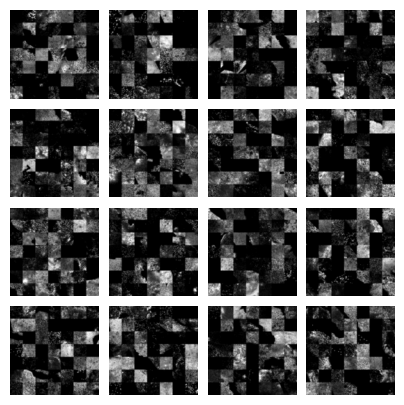

In [113]:
# Get a batch of 25 images for visualization
dataiter = iter(quilted_dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [115]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

In [120]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 10
epochs = 20
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cuda")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in quilted_dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

Epoch 1/20, Loss: 263343.0046, Time: 8.01 sec
Epoch 2/20, Loss: 249316.8423, Time: 7.56 sec
Epoch 3/20, Loss: 248772.5740, Time: 7.48 sec
Epoch 4/20, Loss: 248577.9670, Time: 7.70 sec
Epoch 5/20, Loss: 247830.2513, Time: 8.51 sec
Epoch 6/20, Loss: 246552.6743, Time: 7.77 sec
Epoch 7/20, Loss: 245197.1722, Time: 7.51 sec
Epoch 8/20, Loss: 244175.0941, Time: 7.70 sec
Epoch 9/20, Loss: 243881.9165, Time: 7.67 sec
Epoch 10/20, Loss: 243704.5084, Time: 8.35 sec
Epoch 11/20, Loss: 243580.3844, Time: 7.76 sec
Epoch 12/20, Loss: 243104.2206, Time: 8.05 sec
Epoch 13/20, Loss: 242800.5825, Time: 7.47 sec
Epoch 14/20, Loss: 242681.4947, Time: 7.40 sec
Epoch 15/20, Loss: 242593.3031, Time: 7.59 sec
Epoch 16/20, Loss: 242531.3805, Time: 7.11 sec
Epoch 17/20, Loss: 242474.1939, Time: 7.47 sec
Epoch 18/20, Loss: 242408.1198, Time: 7.34 sec
Epoch 19/20, Loss: 242327.6413, Time: 7.21 sec
Epoch 20/20, Loss: 242311.9190, Time: 7.10 sec


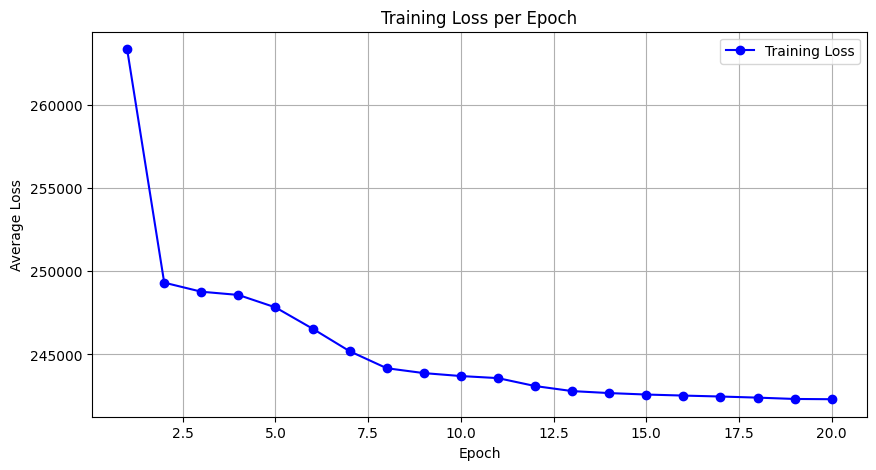

In [121]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

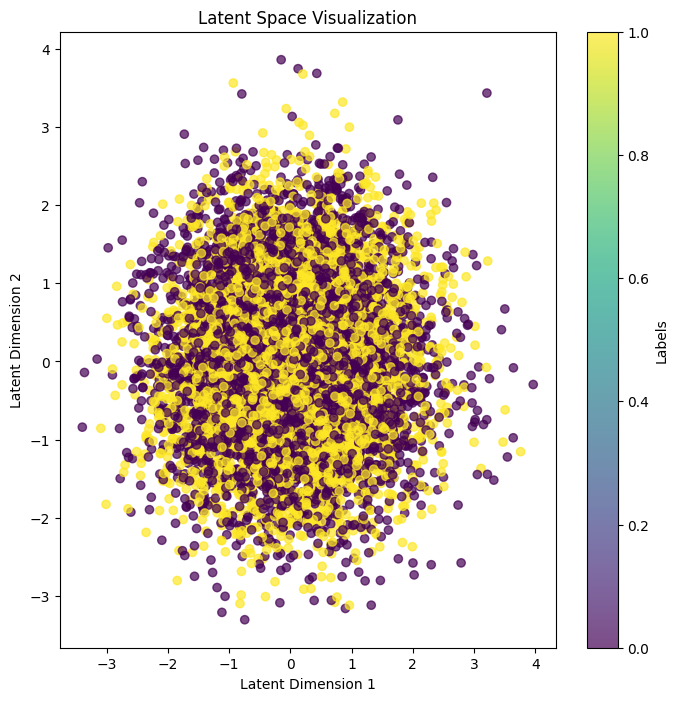

In [122]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, use_tsne=False):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if use_tsne:
            latents_2d = TSNE(n_components=2).fit_transform(latents)
        else:
            latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, quilted_dataloader, latent_dim=10, use_tsne=False)


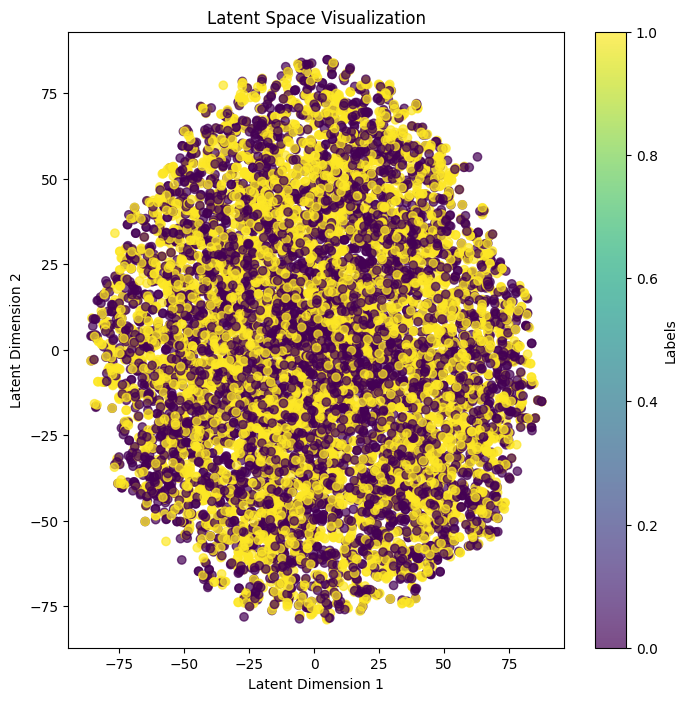

In [124]:
visualize_latent_space(model, quilted_dataloader, latent_dim=10, use_tsne=True)